<a href="https://colab.research.google.com/github/Warvito/vq-vae/blob/master/1%20-%20Autoregressive%20Models%20-%20PixelCNN/pixelCNN_w_4_levels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoregressive Models - PixelCNN

The autoregressive models are generative models that provides an explicit parametric specification of a likelihood function of a variable by specifying it with its parameters. However, to model data that have several dimensions/features, autoregressive models need to define some constraints. First, the observation space X need to have a determining ordering for its features. That is why autoregressive models are naturally used for time series that have a sequence of time steps. However, it can also be employed for images by defining, for example, that the pixels from left come before from the ones in the right, and the ones in the top before the ones in the bottom. Second, to tractably model the joint distribution of the features in a data observation (p(x)), the autoregressive approach cast p(x) as a product of conditional distributions. Autoregressive models define the joint distribution using conditionals over each feature given the values of the previous features. For example, the probability of a pixel from an image to have a specific value is conditioned by the values of all previous pixels; and the probability of an image (the joint distribution) is the combination of the probability of all its pixels. This way, autoregressive models use the chain rule to decompose the likelihood of the data sample x into a product of 1-dimensional distributions (Eq. 1). The factorization turns the joint modelling problem into a sequence problem, where one learns to predict the next pixel given all the previously generated pixels.

***IMAGE***

This is what mainly define an autoregressive model.

Now, the big challenge is how to represent these conditional this p(xi) that usually has a really complex distribution. How could we define it in an expressive model that are also tractable and scalable? One solution is using deep neural networks. 


## PixelCNN
PixelCNN was introduced by DeepMind in 2016 (Oord et al, 2016) and it started one of the most promising families of autoregressive generative models. PixelCNN is a deep neural network that captures the distribution of dependencies between pixels in the parameters. It sequentially generates one pixel at a time in an image along the two spatial dimensions. 



In this implementation, we used the new Tensorflow 2.0 framework. In the fisrt step we install and import the code dependencies.

In [0]:
! pip3 install tensorflow-gpu==2.0.0-rc1

In [0]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

Then, we define the random seeds to have reproducible results and we load the MNIST dataset to train the PixelCNN.

In [0]:
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)

In [0]:
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, 1)
x_test = x_test.reshape(x_test.shape[0], height, width, 1)

In this example, to make the probability distribution of a single pixel easier to be defined, we decide to quantisise the number of possible values that a pixel could have. Originally, in the MNIST dataset the pixel are represented bya  a uint8 variable, beeing able assume values between [0, 255]. In this example, we restring the image to have only 4 different values ([0, 3]).

In [0]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')

In [0]:
# Quantise the input data in q levels
q_levels = 4
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)

Using the tensorflow.Data API, we defined the input data streams for our model during the training and the evaluation. In these dataset, we define the inputs as the images with the 4 levels normaized to be between [0, 1] and the target values are the categoricals pixels values between [0, 3].

In [0]:
# Creating input stream using tf.data API
batch_size = 256
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Masked Convolutions

When using the convolution operations, PixelCNN can parallelly learn the distribution of all pixels in the image. However, the receptive field of a standard convolutional violates the sequential prediction of autoregressive models. When processing the data of a central pixel, the convolutional filter considers all the pixels around it to calculate the output feature map, not only the previous pixels. 

To solve this problem, masks are adopted block information flow from the future pixels.

Masking can be done by zeroing out all the pixels that should not be considered. In our implementation, a mask with the same size to the convolutional filter with values 1 and 0 was created. This mask was multiplied with the weight tensor before doing the convolution operation.

In the pixelCNN, there are two types of masks: type A and type B.

*	Mask A: this mask is applied only to the first convolutional layer. It restricts to access to the pixel of interest by zeroing the center pixel in mask. This way, we guarantee model will not access the pixel that it is about to predict. 

*	Mask B: This mask is applied to all the subsequent convolutional layers and relaxes the restrictions of mask A by allowing the connection from a pixel to itself. 

Below, we have the masks defined inside a keras layer named MasekdConv2D. In this layer, besides the parameters weigths and bias, we have the constant mask defininng the pixels to be zeroed and the type of mask (A or B) (Lines 41 to 47).

Finally, the mask is applied before the convolution (Line 50).


In [0]:
class MaskedConv2D(tf.keras.layers.Layer):
    """Convolutional layers with masks for autoregressive models

    Convolutional layers with simple implementation to have masks type A and B.
    """

    def __init__(self,
                 mask_type,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='same',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'):
        super(MaskedConv2D, self).__init__()

        assert mask_type in {'A', 'B'}
        self.mask_type = mask_type

        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel",
                                      shape=(self.kernel_size,
                                             self.kernel_size,
                                             int(input_shape[-1]),
                                             self.filters),
                                      initializer=self.kernel_initializer,
                                      trainable=True)

        self.bias = self.add_weight("bias",
                                    shape=(self.filters,),
                                    initializer=self.bias_initializer,
                                    trainable=True)

        mask = np.ones(self.kernel.shape, dtype=np.float32)
        mask[self.kernel_size // 2, self.kernel_size // 2 + (self.mask_type == 'B'):, :, :] = 0.
        mask[self.kernel_size // 2 + 1:, :, :] = 0.

        self.mask = tf.constant(mask,
                                dtype=tf.float32,
                                name='mask')

    def call(self, input):
        masked_kernel = tf.math.multiply(self.mask, self.kernel)
        x = tf.nn.conv2d(input, masked_kernel, strides=[1, self.strides, self.strides, 1], padding=self.padding)
        x = tf.nn.bias_add(x, self.bias)
        return x

## Residual blocks

Another element that compose the PixelCNN architecture is the residual blocks.

In [0]:
class ResidualBlock(tf.keras.Model):
    """Residual blocks that compose pixelCNN

    Blocks of layers with 3 convolutional layers and one residual connection.
    Based on Figure 5 from [1] where h indicates number of filters.

    Refs:
    [1] - Oord, A. V. D., Kalchbrenner, N., & Kavukcuoglu, K. (2016). Pixel
     recurrent neural networks. arXiv preprint arXiv:1601.06759.
    """

    def __init__(self, h):
        super(ResidualBlock, self).__init__(name='')

        self.conv2a = keras.layers.Conv2D(filters=h, kernel_size=1, strides=1)
        self.conv2b = MaskedConv2D(mask_type='B', filters=h, kernel_size=3, strides=1)
        self.conv2c = keras.layers.Conv2D(filters=2 * h, kernel_size=1, strides=1)

    def call(self, input_tensor):
        x = tf.nn.relu(input_tensor)
        x = self.conv2a(x)

        x = tf.nn.relu(x)
        x = self.conv2b(x)

        x = tf.nn.relu(x)
        x = self.conv2c(x)

        x += input_tensor
        return x

## PixelCNN architecture

In Oord et al. 2016, the PixelCNN uses the following architecture (Figure X):

**FIGURA**

the first layer is a masked convolution (type A) with 7x7 filters. Then, 15 residuals blocks were used. Each block process the data with a combination of 3x3 layers convolutional layers with mask type B and 1x1 standard convolutional layers. Between each convolutional layer there is also a non-linearity ReLU. After these layers, a residual connection is added. Finally, the network has a sequence of RELU-CONV-RELU-CONV using standard convolutional layers, where both have 1x1 filters. Then, the output layer is a softmax layer which predicts the value among all possible values of a pixel. So, this softmax layer had the image dimension (because we want an output value for each pixel) times the number of possible values (for example, 256 pixels values).

In [0]:
# Create PixelCNN model
inputs = keras.layers.Input(shape=(height, width, n_channel))
x = MaskedConv2D(mask_type='A', filters=128, kernel_size=7, strides=1)(inputs)

for i in range(15):
    x = ResidualBlock(h=64)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In this implementation we use a simple Adam optimizer with learning rate decay to train the neural network. The loss function is defined by the crossentropy (that in this case is equivalent to minimizing the negative log-likelihood of the training data).

In [0]:
# Prepare optimizer and loss function
lr_decay = 0.9995
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

The training step is defined by the forward propagation throgh the model, and then the outputs are reshaped to work with several inputs channels (like RGB channels). Finally, the gradients are calculated, clipped to be between [-1, 1], and applied to upgrade the PixelCNN parameters.

In [0]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss

In this implementation, we defined the trainig loop with 30 epochs.

In [0]:
# Training loop
n_epochs = 30
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))


EPOCH   0: ITER    0/ 235 TIME: 6.42 LOSS: 1.3943
EPOCH   0: ITER  100/ 235 TIME: 0.91 LOSS: 0.1695
EPOCH   0: ITER  200/ 235 TIME: 0.91 LOSS: 0.1603
EPOCH   0: TIME: 223.48 ETA: 6704.53
EPOCH   1: ITER    0/ 235 TIME: 0.03 LOSS: 0.1632
EPOCH   1: ITER  100/ 235 TIME: 0.91 LOSS: 0.1561
EPOCH   1: ITER  200/ 235 TIME: 0.91 LOSS: 0.1529
EPOCH   1: TIME: 215.46 ETA: 6248.45
EPOCH   2: ITER    0/ 235 TIME: 0.03 LOSS: 0.1595
EPOCH   2: ITER  100/ 235 TIME: 0.91 LOSS: 0.1495
EPOCH   2: ITER  200/ 235 TIME: 0.93 LOSS: 0.1465
EPOCH   2: TIME: 215.54 ETA: 6035.08
EPOCH   3: ITER    0/ 235 TIME: 0.03 LOSS: 0.1514
EPOCH   3: ITER  100/ 235 TIME: 0.92 LOSS: 0.1492
EPOCH   3: ITER  200/ 235 TIME: 0.91 LOSS: 0.1498
EPOCH   3: TIME: 215.44 ETA: 5817.01
EPOCH   4: ITER    0/ 235 TIME: 0.03 LOSS: 0.1493
EPOCH   4: ITER  100/ 235 TIME: 0.92 LOSS: 0.1449
EPOCH   4: ITER  200/ 235 TIME: 0.91 LOSS: 0.1494
EPOCH   4: TIME: 215.59 ETA: 5605.28
EPOCH   5: ITER    0/ 235 TIME: 0.03 LOSS: 0.1458
EPOCH   5: ITER

To evaluate the performance of the model, we measured the NLL of the model in the test set. 

In [0]:
# Test
test_loss = []
for batch_x, batch_y in test_dataset:
    logits = pixelcnn(batch_x, training=False)
    logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
    logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])

    # Calculate cross-entropy (= negative log-likelihood)
    loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    test_loss.append(loss)
print('nll : {:} nats'.format(np.array(test_loss).mean()))
print('bits/dim : {:}'.format(np.array(test_loss).mean() / (height * width)))

nll : 0.14044268429279327 nats
bits/dim : 0.00017913607690407305


Finally, we sampled some images from the trained model. First, we sampled from the scratch, then we completed imaged partially occluded.

In [0]:
def sample_from(distribution):
    """Sample random values from distribution"""
    batch_size, bins = distribution.shape
    return np.array([np.random.choice(bins, p=distr) for distr in distribution])

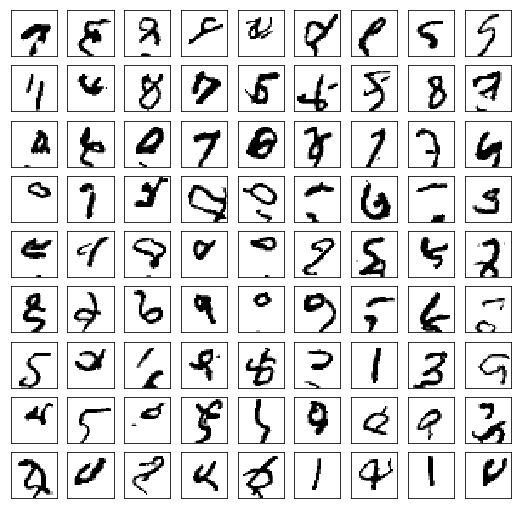

In [0]:
# Generating new images
samples = (np.random.rand(100, height, width, n_channel) * 0.01).astype('float32')
for i in range(28):
    for j in range(28):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        probs = tf.nn.softmax(logits)
        next_sample = probs[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)

fig = plt.figure(figsize=(10, 10))
for x in range(1, 10):
    for y in range(1, 10):
        ax = fig.add_subplot(10, 10, 10 * y + x)
        ax.matshow(samples[10 * y + x, :, :, 0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.show()

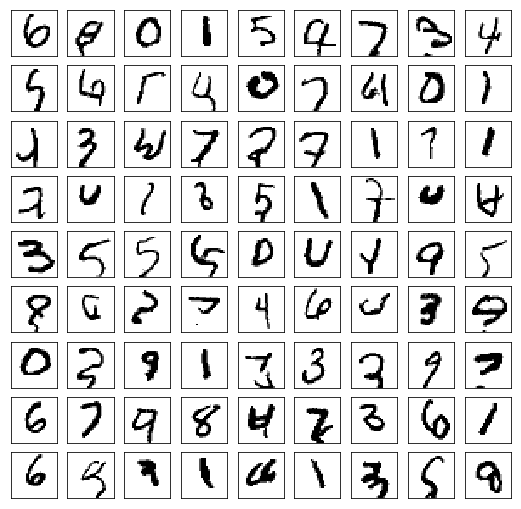

In [0]:
# Filling occluded images
occlude_start_row = 14
num_generated_images = 100
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        probs = tf.nn.softmax(logits)
        next_sample = probs[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)

fig = plt.figure(figsize=(10, 10))
for x in range(1, 10):
    for y in range(1, 10):
        ax = fig.add_subplot(10, 10, 10 * y + x)
        ax.matshow(samples[10 * y + x, :, :, 0], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
plt.show()